# Anomaly Detection - Algorithms in Machine Learning

Table of contents:
1. [Context](#sec1)
2. [Problem formulation](#sec2)
    1. [First data investigation](#sec2-1)
    2. [Problem description](#sec2-2)
3. [Methods](#sec3)
4. [Results](#sec4)
5. [Conclusion](#sec5)
    1. [Anomaly detection](#sec5-1)
    2. [Open questions](#sec5-2)

## 1. <a id="sec1"></a>Context

Aircraft systems are recording values of parameters such as speed, temperature, pressure, electrical current values... 

The measures are divided into sections of window. Each window contains 100 measure points. The window is the smallest unit of sections. Beyond this, each cycle contains several windows and each day contains several cycles. 

The dataset contains 162702 lines and 12 colomns with 11 parameters and 1 label "day_cycle_window".

With this dataset, an aircraft system expert is searching for the help of data scientist to "build an algorithm to detect windows that are abnormal".

## 2. <a id="sec2"></a>Problem formulation

Data scientists need to have a global understanding of the data to be able to provide the appropriate formulation of the problem. The first question that we ask is how to summerize information on the window scale based on the fact that we have 100 data points for each window. The second question is that what kind of anomalies that we are facing and how to define anomalies. The last step is to discuss with the expert, in order to show them what information can we get from the provided data and what supplementary information that we need to identify the "anomalies".


### A. <a id="sec2-1"></a>First data investigation

#### A.1 Count windows and data points per window

Firstly, some general information needs to be provided.

In [4]:
# Necessary library importation for this section
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

In [37]:
dataset = pd.read_csv("dataset.csv")
index_window, num_perwindow = np.unique(dataset["day_cycle_window"], return_counts = True)
print(f'The dataset contains {len(index_window)} windows.')
print(f'The number of data points from each window varies from {num_perwindow.min()} to {num_perwindow.max()}.')

The dataset contains 1637 windows.
The number of data points from each window varies from 2 to 100.


<div class="alert alert-block alert-warning">
<b>Attention:</b> For some windows, the measure points were too little to provide the statistical information for the window.
</div>

We can then deduce the **first type of anomaly**: the problem of measurements, meaning that during a specific window, the measure points can not reach 100 times, showing a discontinuity of measurements in this window. This can be a discussion point with aircraft system expert, asking for the confirmation of potential measuring problems.

In [86]:
num_perwindow_sorted = np.sort(num_perwindow)
l = len(num_perwindow_sorted[num_perwindow_sorted!=100])
print(f'The number of windows for which the number of data points is not 100 is : {l}.')
index_anomaly1 = np.argsort(num_perwindow)[:l]
window_anomaly1 = index_window[index_anomaly1]
print(f'The corresponding windows are {window_anomaly1}.')

The number of windows for which the number of data points is not 100 is : 15.
The corresponding windows are ['3_3_181' '2_1_181' '3_1_181' '1_2_181' '4_2_181' '3_2_52' '1_5_94'
 '4_3_65' '2_3_145' '1_4_17' '1_3_6' '2_2_76' '1_1_68' '4_4_160' '4_1_49'].


Before confirming this point, we will do an assumption that all the windows need to have 100 times of measurements to be considered to be normal. So for the following sections, only "normal windows" with 100 points will be conserved.

In [97]:
# filter the dataset to save only the windows with 100 data points
dataset_no1anomaly = dataset[~dataset.day_cycle_window.isin(window_anomaly1)]

#### A.2 Check the information of a random window

In order to detect the anomaly on a window basis, one needs to extract the features from each window for each parameter. Which statistics to be chosen is the core problem of this step. In order to answer this question, we want to explore the data distribution of each window for each variable.

The window selected is ['3_1_139']


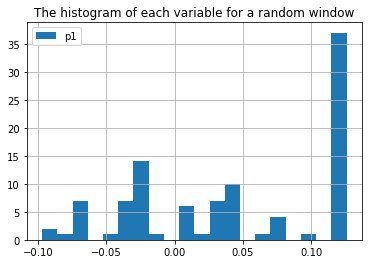

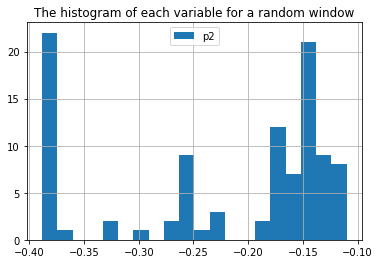

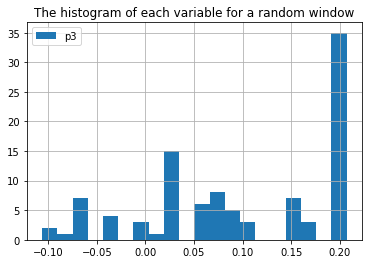

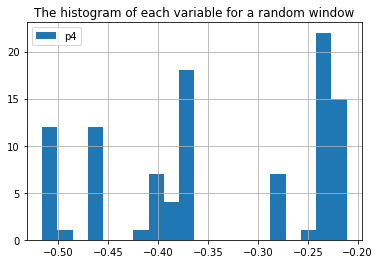

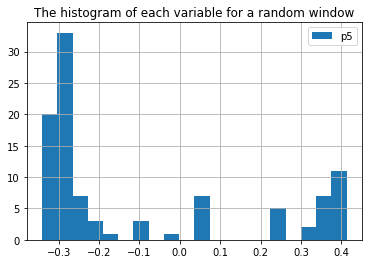

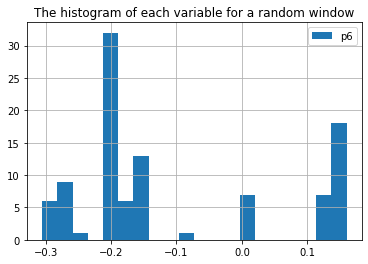

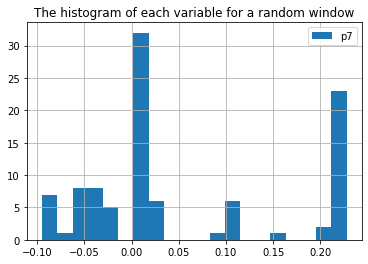

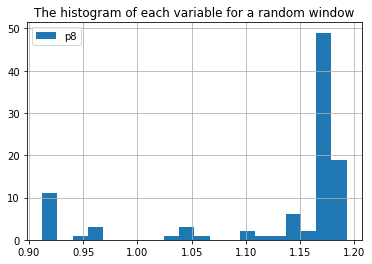

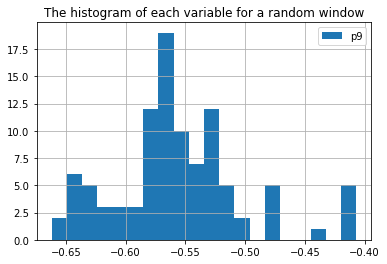

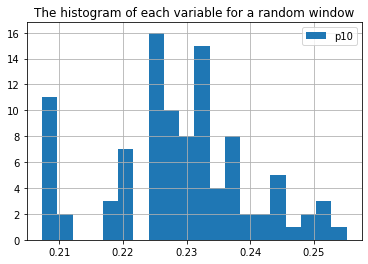

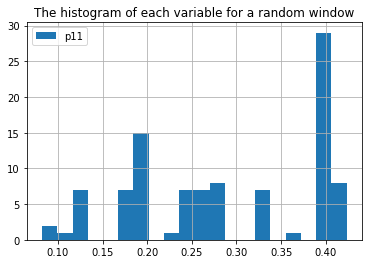

In [120]:
window_no1anomaly = np.setdiff1d(index_window, window_anomaly1)
random_window = np.random.choice(window_no1anomaly, size = 1)
print(f'The window selected is {random_window}'.)
for i in np.arange(1,dataset.shape[1]):
    plt.figure()
    dataset[dataset.day_cycle_window == random_window[0]].iloc[:,i].hist(bins = 20, label = dataset.columns[i])
    plt.title("The histogram of each variable for a random window")
    plt.legend()

In the above section, we have selected randomly a window to see the distribution of each variables. In these histograms, the distribution is not actually Gaussian for many variables. In fact, we can see several peaks on the graph, showing a bimodal or multimodal distribution. In order to compare the distribution of different windows for the same variable, we run again the above code.

The window selected is ['4_4_73'].


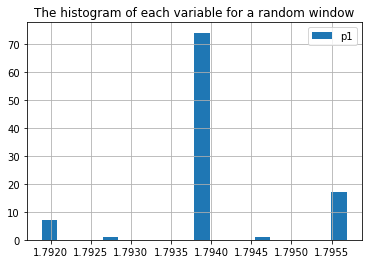

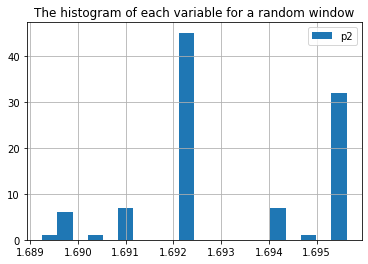

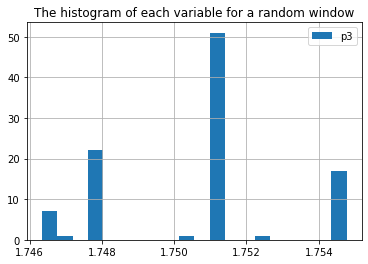

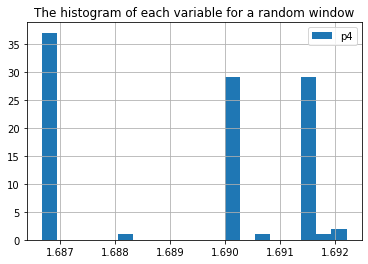

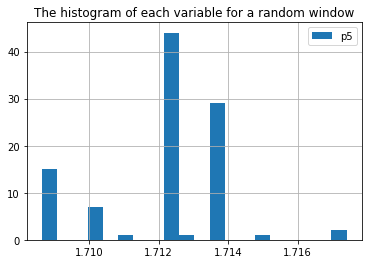

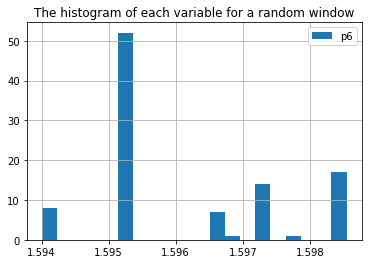

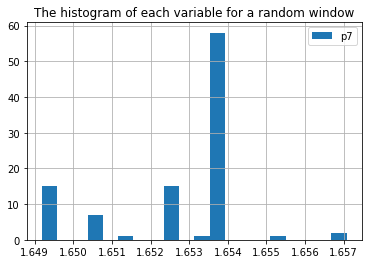

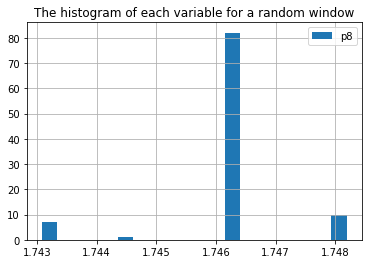

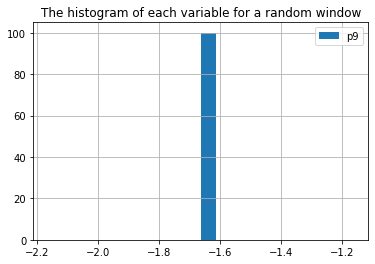

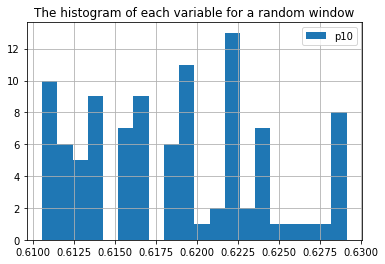

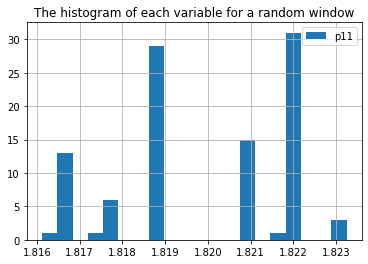

In [122]:
random_window = np.random.choice(window_no1anomaly, size = 1)
print(f'The window selected is {random_window}.')
for i in np.arange(1,dataset.shape[1]):
    plt.figure()
    dataset[dataset.day_cycle_window == random_window[0]].iloc[:,i].hist(bins = 20, label = dataset.columns[i])
    plt.title("The histogram of each variable for a random window")
    plt.legend()

By a rough comparaison, we can see that even for the same variable, we do have different distributions for different windows. Again, few of them are following the Gaussian distribution. Thus, it is not appropriate to use the mean and the variance to summerize the information on each window. 

<div class="alert alert-block alert-warning">
<b>Proposition:</b> We use the median and the median absolute deviation (MAD) to obtain robust descriptors for each variable and each window.
</div>

Here we recall the definition of the median absolute deviation (MAD):
$$MAD = median(|x-median(x)|)$$

#### A.3 Global data investigation

Before getting to the process of anomaly detection, we want to make sure that the data is clean enough, meaning there is no null value.

In [129]:
print(f'Is there any missed value in the dataframe? {dataset_no1anomaly.isnull().values.any()}!')

Is there any missed value in the dataframe? False!


In [130]:
dataset_no1anomaly.describe()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
count,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000,162200.000000
mean,0.000396,-0.000680,-0.002286,-0.000366,-0.000363,0.000805,0.000823,0.000291,0.002817,-0.001299,-0.002914
std,0.999141,0.998478,0.995442,0.998792,0.998532,0.998860,0.999383,0.999187,0.992008,0.987465,0.994999
min,-3.211980,-3.395387,-3.325651,-3.378450,-3.281286,-4.200181,-3.898025,-3.524957,-13.704556,-10.621700,-3.183571
25%,-0.678808,-0.482556,-0.629276,-0.491163,-0.611638,-0.559023,-0.605228,-0.737095,-0.590086,-0.499300,-0.658530
50%,0.042896,0.179877,0.040733,0.147397,0.117040,0.154443,0.186879,-0.011674,-0.032984,-0.257635,-0.016261
75%,0.743797,0.655579,0.656998,0.636887,0.711965,0.684938,0.719222,0.802395,0.508989,0.357578,0.633398
max,5.013899,6.260782,8.652950,8.359670,6.424227,5.638259,3.735957,4.667058,8.203706,5.597387,9.204384


A brief check on the data tells us that the data is quite centered (mean closed to 0 for each variable), and with a standard deviation closed to 1. Thus no more preprocess step is to be conducted.

### B. <a id="sec2-2"></a>Problem description
The problem can be divided into some subproblems:
+ Summerizing information for each window
+ Proposing methodologies to detect anomalies
+ Setting thresholds for the detection

As shown in the previous section, as the distribution of variables in each window is not always normal, we use median and MAD to describe the center and dispersion of the data in each window. With median, we can describe if some windows have overall deviation from others. With MAD, we can describe if the dispersion of some window is too large which may induced by the measurement problems. Two types of anomalies can be observed here.

With median and MAD dataset, we can propose some machine learning methodologies for multivariante case of anomaly detection.

Then the preliminary result can be presented to the experts in order to have a feedback and set the thresholds for anomalies.
